In [51]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.interpolate import interp1d
from default_globals import *
import h5py
from scipy import stats
from scipy.integrate import romb
from tqdm import tqdm
from redshift_utils import *
from utils import make_nice_plots
make_nice_plots()

In [60]:
VERBOSE = True

ZMIN = 1e-4  # Some buffer for astropy's lowest possible value
ZMAX = 1.5   # Maximum true redshift for GWs, such that p_rate(z > ZMAX) = 0
AGN_ZMAX = 1.5
# assert AGN_ZMAX >= ZMAX, 'Need AGN at least as deep as GWs can go, otherwise the population prior is not evaluated on the correct axis.'  # Don't think this is true anymore
COMDIST_MIN = COSMO.comoving_distance(ZMIN).value
COMDIST_MAX = COSMO.comoving_distance(ZMAX).value
AGN_COMDIST_MAX = COSMO.comoving_distance(AGN_ZMAX).value

ASSUME_PERFECT_REDSHIFT = False
AGN_ZERROR = 'quaia'
if AGN_ZERROR == 'quaia':
    quaia_errors = pd.read_csv("/home/lucas/Documents/PhD/Quaia_z15.csv")["redshift_quaia_err"]  # Load into memory and sample later

S_AGN_Z_INTEGRAL_AX = np.linspace(ZMIN, ZMAX, int(512)+1)  # Sets the resolution of the redshift prior, should capture all information of AGN posteriors, see Gray et al. 2022, 2023
S_ALT_Z_INTEGRAL_AX = S_AGN_Z_INTEGRAL_AX.copy()  # No reason found yet to have a different axis here
LINAX = True  # If geomspace instead of linspace, make False
if not ASSUME_PERFECT_REDSHIFT:
    if AGN_ZERROR == 'quaia':
        smallest_error = np.min(quaia_errors)
    else:
        smallest_error = AGN_ZERROR
    npoints = int(2**np.ceil(np.log2(10 * (AGN_ZMAX - ZMIN) / smallest_error)))  # Enforces at least 10 points within 1 sigma in normalization of AGN posteriors -> 
    AGN_POSTERIOR_NORM_AX = np.linspace(ZMIN, AGN_ZMAX, npoints + 1)


def compute_and_save_posteriors_hdf5(filename, all_agn_z, all_agn_z_err, prior=False):
    '''
    AGN redshift posteriors are modelled as truncnorms on [0, inf) with a uniform-in-comoving-volume redshift prior.
    The posteriors are normalized on agn_posterior_norm_ax, which goes up to AGN_ZMAX.
    The posteriors are then evaluated on S_AGN_Z_INTEGRAL_AX, which is what is necessary for the crossmatch.
    '''

    maxdiff = np.max(np.diff(AGN_POSTERIOR_NORM_AX))
    thresh = np.min(all_agn_z_err) / 10
    assert maxdiff < thresh, f'AGN normalization array is too coarse to capture AGN distribution fully. Got {maxdiff:.3e}, need {thresh:.3e}.'

    n_agn = len(all_agn_z)
    n_z = len(S_AGN_Z_INTEGRAL_AX)  # Only need to save the posterior evaluated at this axis
    chunk_size = int(1e6 / n_z)
    dx = np.diff(AGN_POSTERIOR_NORM_AX)[0]  # For romb integration
    with h5py.File(filename, "w") as f:
        dset = f.create_dataset("agn_redshift_posteriors", shape=(n_agn, n_z), dtype=np.float64)

        if VERBOSE:
            iterchunks = tqdm( range(0, n_agn, chunk_size) )
        else:
            iterchunks = range(0, n_agn, chunk_size)

        for start in iterchunks:
            end = min(start + chunk_size, n_agn)

            z_chunk = all_agn_z[start:end]
            zerr_chunk = all_agn_z_err[start:end]

            likelihood = lambda z: stats.truncnorm.pdf(
                z,
                a=(ZMIN - z_chunk[:, None]) / zerr_chunk[:, None],
                b=(np.inf - z_chunk[:, None]) / zerr_chunk[:, None],
                loc=z_chunk[:, None],
                scale=zerr_chunk[:, None]
            )

            if prior == 'unif_comvol':
                agn_posteriors_unnorm = lambda z: likelihood(z) * z_cut(z, zcut=AGN_ZMAX) * uniform_comoving_prior(z)
            elif prior in [45.0, 45.5, 46.0, 46.5]:
                pi = np.load(f'zprior_{prior}.npy')
                z_interp = np.load('z_ax.npy')
                zprior = interp1d(z_interp, pi, bounds_error=False, fill_value='extrapolate')
                agn_posteriors_unnorm = lambda z: likelihood(z) * z_cut(z, zcut=AGN_ZMAX) * zprior(z)
            else:
                agn_posteriors_unnorm = lambda z: likelihood(z) * z_cut(z, zcut=AGN_ZMAX) * z_cut(-z, zcut=0)

            z_norms = romb(agn_posteriors_unnorm(AGN_POSTERIOR_NORM_AX), dx=dx)
            posteriors = agn_posteriors_unnorm(S_AGN_Z_INTEGRAL_AX) / z_norms[:, None]  # Save the posterior evaluated at the relevant axis

            dset[start:end, :] = posteriors
    if VERBOSE:
        print(f"All AGN posteriors written to {filename}")
    return


In [3]:
CATALOG_PATH = "/home/lucas/Documents/PhD/Quaia_z15.csv"
LUM_THRESH = '45.0'

df = pd.read_csv(CATALOG_PATH)
cols = ["redshift_quaia", "redshift_quaia_err", "ra", "dec", "b", "loglbol_corr"]
data = df[cols]
b              = data["b"].to_numpy()
loglbol_corr   = data["loglbol_corr"].to_numpy()
outside_galactic_plane = np.logical_or((b > 10), (b < -10))
above_lbol_thresh = loglbol_corr >= float(LUM_THRESH)

b                  = b[outside_galactic_plane & above_lbol_thresh]
loglbol_corr       = loglbol_corr[outside_galactic_plane & above_lbol_thresh]
agn_redshift       = data["redshift_quaia"].to_numpy()[outside_galactic_plane & above_lbol_thresh]
agn_redshift_err   = data["redshift_quaia_err"].to_numpy()[outside_galactic_plane & above_lbol_thresh]
agn_ra             = np.deg2rad( data["ra"].to_numpy()[outside_galactic_plane & above_lbol_thresh] )
agn_dec            = np.deg2rad( data["dec"].to_numpy()[outside_galactic_plane & above_lbol_thresh] )
agn_rlum           = COSMO.luminosity_distance(agn_redshift).value

# agn_posterior_dset, redshift_population_prior_normalization, sum_of_posteriors_incomplete = get_agn_posteriors_and_zprior_normalization(fagn_idx, agn_redshift, agn_redshift_err, label=LUM_THRESH, replace_old_file=False)
# _, c_per_zbin, completeness_map = make_incomplete_catalog(agn_ra, agn_dec, agn_rlum, agn_redshift)  # Quaia is already redshift incomplete, but convenient to get completeness maps this way


In [4]:
filename = f'./quaia_testing_{LUM_THRESH}.hdf5'
# compute_and_save_posteriors_hdf5(filename, agn_redshift, agn_redshift_err)

/tmp/ipykernel_2904488/2497505617.py:30: RuntimeWarning: divide by zero encountered in divide
  ax.plot(S_AGN_Z_INTEGRAL_AX, sum_of_posteriors / completeness, label='Implied complete', linewidth=2)
/tmp/ipykernel_2904488/2497505617.py:31: RuntimeWarning: divide by zero encountered in divide
  ax.plot(S_AGN_Z_INTEGRAL_AX, uniform_comoving_prior(S_AGN_Z_INTEGRAL_AX) / np.mean(uniform_comoving_prior(S_AGN_Z_INTEGRAL_AX)) * np.mean(sum_of_posteriors / completeness), label=r'$\propto dV/dz$', linewidth=2)


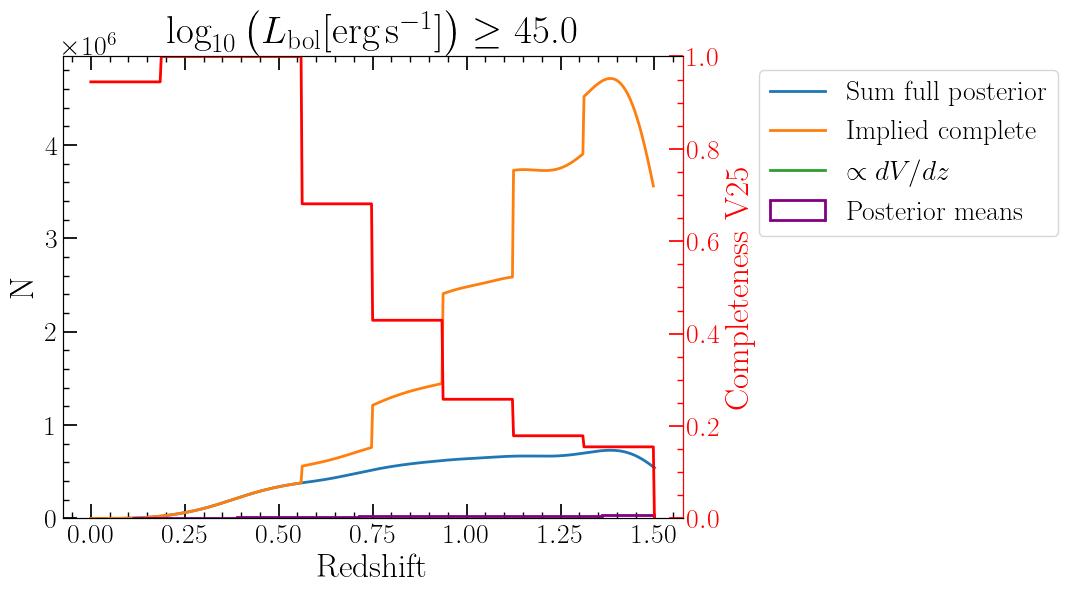

In [5]:
AGN_ZCUT = 1.5

THRESHOLD_MAP = {"46.5": 0, "46.0": 1, "45.5": 2, "45.0": 3, "44.5": 4}
Z_EDGES = np.array([0.0000, 0.1875, 0.3750, 0.5625, 0.7500, 0.9375, 1.1250, 1.3125, AGN_ZCUT, AGN_ZMAX])
QUAIA_C_VALS = np.array([
                    [0.000, 0.000, 0.229, 0.945, 0.718],
                    [1.000, 1.000, 1.000, 1.000, 0.781],
                    [1.000, 1.000, 1.000, 1.000, 0.408],
                    [1.000, 0.891, 1.000, 0.681, 0.211],
                    [1.000, 1.000, 0.994, 0.429, 0.138],
                    [1.000, 1.000, 0.837, 0.258, 0.085],
                    [0.927, 0.940, 0.576, 0.179, 0.060],
                    [1.000, 1.000, 0.482, 0.155, 0.053],
                    [0., 0., 0., 0., 0.]
                ])

def redshift_completeness(z, completeness_zedges, completeness_zvals):
    bin_idx = np.digitize(z, completeness_zedges) - 1
    bin_idx[bin_idx == len(completeness_zvals)] = len(completeness_zvals) - 1
    return completeness_zvals[bin_idx.astype(np.int32)]

completeness = redshift_completeness(S_AGN_Z_INTEGRAL_AX, Z_EDGES, np.array(QUAIA_C_VALS[:, THRESHOLD_MAP[LUM_THRESH]]))

with h5py.File(filename, "r") as f:
    agn_posterior_dset = f["agn_redshift_posteriors"][()]
sum_of_posteriors = np.sum(agn_posterior_dset, axis=0)  # Sum of posteriors is required to normalize the in-catalog population prior

fig, ax = plt.subplots(figsize=(8,6))
ax.plot(S_AGN_Z_INTEGRAL_AX, sum_of_posteriors, label='Sum full posterior', linewidth=2)
ax.plot(S_AGN_Z_INTEGRAL_AX, sum_of_posteriors / completeness, label='Implied complete', linewidth=2)
ax.plot(S_AGN_Z_INTEGRAL_AX, uniform_comoving_prior(S_AGN_Z_INTEGRAL_AX) / np.mean(uniform_comoving_prior(S_AGN_Z_INTEGRAL_AX)) * np.mean(sum_of_posteriors / completeness), label=r'$\propto dV/dz$', linewidth=2)
ax.hist(agn_redshift, histtype='step', linewidth=2, bins=30, label='Posterior means', color='purple')
ax.set_ylabel('N')
ax.set_xlabel('Redshift')
ax.legend(bbox_to_anchor=(1.1, 1), loc='upper left')

c_ax = ax.twinx()
c_ax.plot(S_AGN_Z_INTEGRAL_AX, completeness, color='red', linewidth=2)

c_ax.tick_params(axis='y', which='both', colors='red')
c_ax.spines['right'].set_color('red')
c_ax.yaxis.label.set_color('red')
c_ax.set_ylabel('Completeness V25')
c_ax.set_ylim(0, 1)

plt.title(r'$\log_{10} \left( L_{\rm bol} [\mathrm{erg \, s^ {-1}}] \right) \geq$' + f' {LUM_THRESH}')
plt.show()


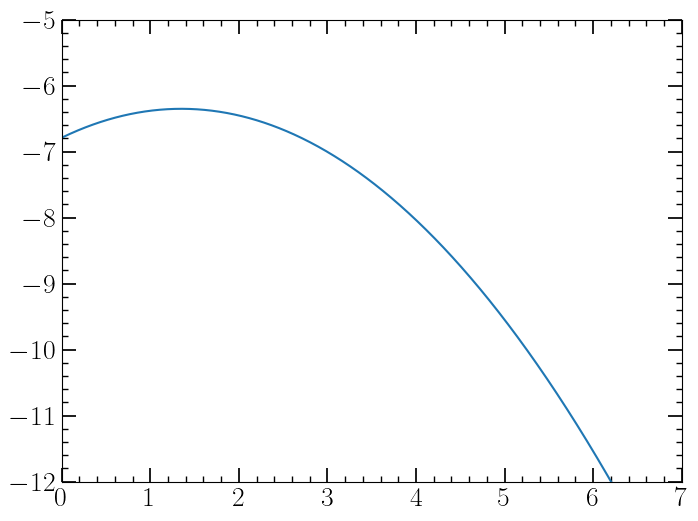

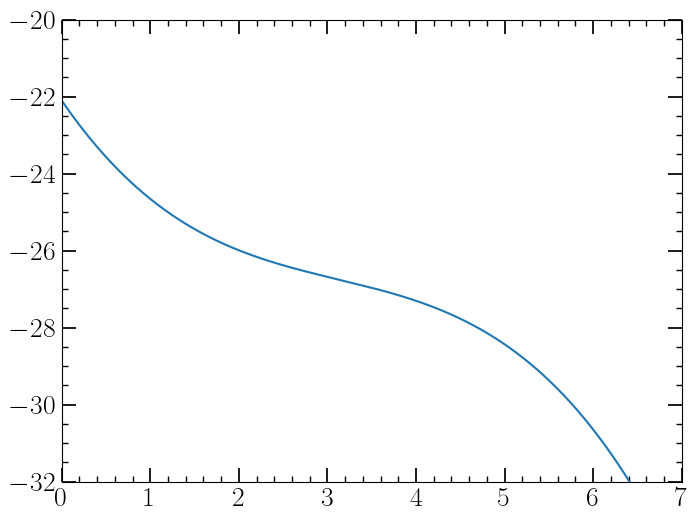

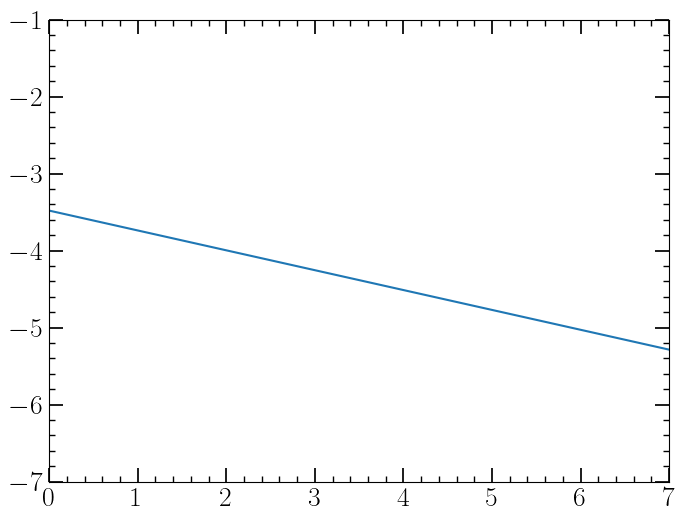

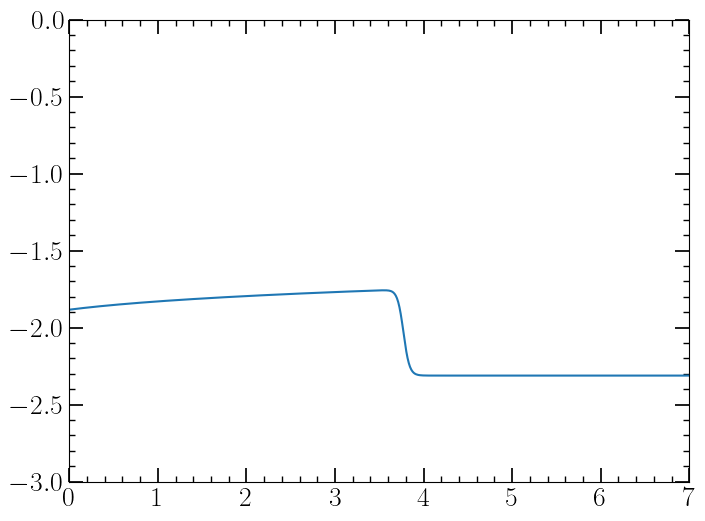

In [6]:
from scipy.special import chebyt

COEFFICIENTS = {
    0: np.array([
        [-7.798, +0.145, -0.157],  # c0,0
        [ 1.128, +0.085, -0.081],  # c0,1
        [-0.120, +0.005, -0.006],  # c0,2
    ]),
    
    1: np.array([
        [-17.163, +0.219, -0.226],   # c1,0
        [ -5.512, +0.127, -0.124],   # c1,1
        [  0.593, +0.011, -0.010],   # c1,2
        [ -0.024, +0.00035, -0.00039], # c1,3
    ]),
    
    2: np.array([
        [ -3.223, +0.127, -0.121],   # c2,0
        [ -0.258, +0.047, -0.051],   # c2,1
    ]),
    
    3: np.array([
        [ -2.312, +0.034, -0.032],   # c3,0
        [  0.559, +0.049, -0.045],   # c3,1
        [  3.773, +0.017, -0.016],   # c3,2
        [141.884, +31.521, -3.832],  # c3,3
        [ -0.171, +0.101, -0.116],   # c3,4
    ])
}


def QLF(M, phi_star, M_star, alpha, beta):
    """
    M: absolute magnitude
    phi_star: amplitude
    M_star: break magnitude
    alpha: bright-end slope
    beta: faint-end slope
    """
    return phi_star / (10**(0.4 * (alpha + 1) * (M - M_star)) + 10**(0.4 * (beta + 1) * (M - M_star)))


# def F(i, z):
#     z = np.atleast_1d(z)
#     x = 1 + z

#     ci_mean = COEFFICIENTS[i][:,0]
#     ci_up = COEFFICIENTS[i][:,1]
#     ci_down = COEFFICIENTS[i][:,2]
#     sig = (ci_up + abs(ci_down)) / 2
#     ci = np.random.normal(ci_mean, sig)

#     if i != 3:
#         Fi_x = np.zeros_like(z)
#         for j, cij in enumerate(ci):
#             Fi_x += cij * chebyt(j)(x)
#         return Fi_x
    
#     else:
#         c30, c31, c32, c33, c34 = ci
#         zeta = np.log10( x / (1 + c32) )
#         return c30 + c31 / (10**(c33 * zeta) + 10**(c34 * zeta))


def F(i, z):
    z = np.atleast_1d(z)
    x = 1 + z
    ci = COEFFICIENTS[i][:,0]
    
    if i != 3:
        Fi_x = np.zeros_like(z)
        for j, cij in enumerate(ci):
            Fi_x += cij * chebyt(j)(x)
        return Fi_x
    
    else:
        c30, c31, c32, c33, c34 = ci
        zeta = np.log10( x / (1 + c32) )
        return c30 + c31 / (10**(c33 * zeta) + 10**(c34 * zeta))


def log10_phi_star_zevo(z):
    return F(0, z)


def M_star_zevo(z):
    return F(1, z)


def alpha_zevo(z):
    return F(2, z)


def beta_zevo(z):
    return F(3, z)


def log10addexp10(a, b):
    return np.maximum(a, b) + np.log10(1 + 10**(-abs(a - b)))


def log10_QLF(M, z):
    """
    M: absolute magnitude
    log10_phi_star: log base 10 of amplitude [mag^-1 cMpc^-3]
    M_star: break magnitude
    alpha: bright-end slope
    beta: faint-end slope
    """
    log10_phi_star = log10_phi_star_zevo(z)
    M_star = M_star_zevo(z)
    alpha = alpha_zevo(z)
    beta = beta_zevo(z)

    term1 = 0.4 * (alpha + 1) * (M - M_star)
    term2 = 0.4 * (beta + 1) * (M - M_star)
    return log10_phi_star - log10addexp10(term1, term2)


def L2M(log10_Lbol):
    """
    Convert bolometric luminosity to absolute magnitude. We use the magnitude-dependent bolometric correction function (Eq. 9) of Runnoe et al. (2012).
    """
    log10_Liso = log10_Lbol - np.log10(0.75)  # Viewing angle correction
    log10_L1450 = (log10_Liso - 4.74) / 0.91
    L0 = 3.0128e28  # J/s
    return -2.5 * (log10_L1450 - np.log10(L0))
    

# print(L2M(45.5 - 7))

# z_eval = 0.72 # 0.31#
# plt.figure()
# # plt.plot(np.linspace(-30, 0, 1000), np.log10( QLF(np.linspace(-30, 0, 1000), phi_star=10**(-5.72), M_star=-21.30, alpha=-2.74, beta=-1.07) ), label='In bin')
# plt.plot(np.linspace(-30, 0, 1000), np.log10( QLF(np.linspace(-30, 0, 1000), phi_star=10**(-6.57), M_star=-24.21, alpha=-3.55, beta=-1.89) ), label='In bin')
# plt.plot(np.linspace(-30, 0, 1000), log10_QLF(np.linspace(-30, 0, 1000), z=z_eval), label='All z')
# plt.legend()
# plt.show()

z_ax = np.linspace(0, 7, 1000)
plt.figure(figsize=(8,6))
plt.plot(z_ax, log10_phi_star_zevo(z_ax))
plt.xlim(0, 7)
plt.ylim(-12, -5)
plt.show()

plt.figure(figsize=(8,6))
plt.plot(z_ax, M_star_zevo(z_ax))
plt.xlim(0, 7)
plt.ylim(-32, -20)
plt.savefig('./mstar2.pdf', bbox_inches='tight')
plt.show()

plt.figure(figsize=(8,6))
plt.plot(z_ax, alpha_zevo(z_ax))
plt.xlim(0, 7)
plt.ylim(-7, -1)
plt.show()

plt.figure(figsize=(8,6))
plt.plot(z_ax, beta_zevo(z_ax))
plt.xlim(0, 7)
plt.ylim(-3, 0)
plt.show()


100%|██████████| 512/512 [00:01<00:00, 426.15it/s]


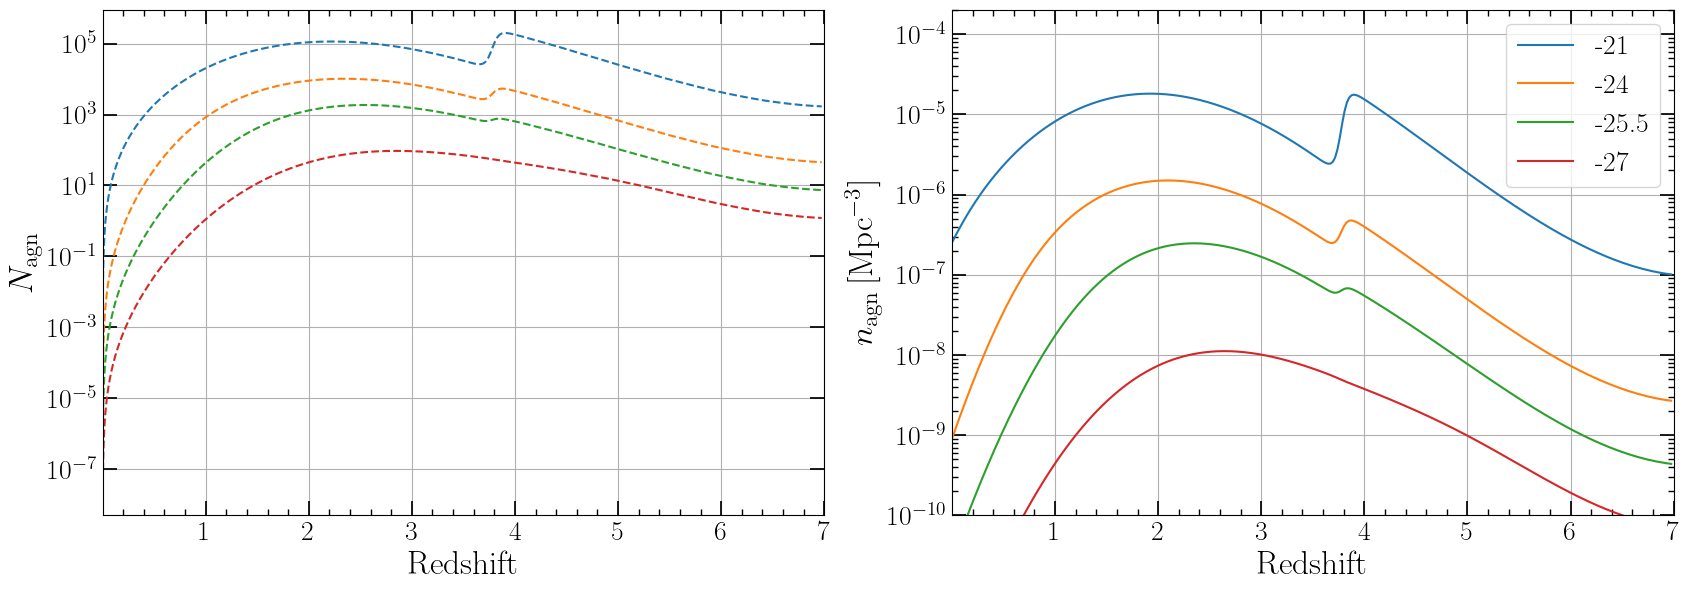

In [25]:
import astropy.units as u

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(17,6))

ZMIN = 1e-6
ZMAX = 7
R_EDGES = np.linspace(COSMO.comoving_distance(ZMIN).value, COSMO.comoving_distance(ZMAX).value, 512+1)
r_mids = (R_EDGES + np.roll(R_EDGES, shift=1))[1:] / 2
z_mids = fast_z_at_value(COSMO.comoving_distance, r_mids * u.Mpc)

for magthresh in [-21, -24, -25.5, -27]:

    mag_integrate_axis = np.linspace(-50, magthresh, int(128)+1)
    n_of_r = lambda r: romb(10**log10_QLF(mag_integrate_axis[:,np.newaxis], z=fast_z_at_value(COSMO.comoving_distance, r * u.Mpc))[np.newaxis,:], dx=np.diff(mag_integrate_axis)[0], axis=1)  # Function of comoving distance
    numdenses = n_of_r(r_mids).flatten()

    nums = []
    for i in tqdm(range(len(R_EDGES) - 1)):
        r_integrate_ax = np.linspace(R_EDGES[i], R_EDGES[i + 1], 256+1)
        numdens = n_of_r(r_integrate_ax)
        # num = romb(numdens * COSMO.differential_comoving_volume(fast_z_at_value(COSMO.comoving_distance, r_integrate_ax * u.Mpc)), dx=np.diff(r_integrate_ax)[0], axis=1)
        num = 4 * np.pi * romb(numdens * r_integrate_ax**2, dx=np.diff(r_integrate_ax)[0], axis=1)
        nums.append(num)

    ax1.plot(z_mids, nums, linestyle='dashed', label=magthresh)
    ax2.plot(z_mids, numdenses, label=magthresh)

ax2.legend()
# ax1.vlines(Z_EDGES, 1e-1, 5e6)
ax1.grid()
ax1.semilogy()
ax1.set_xlim(ZMIN, ZMAX)
# ax1.set_ylim(1e-1, 5e6)
ax1.set_xlabel('Redshift')
ax1.set_ylabel(r'$N_{\rm agn}$')

ax2.set_xlabel('Redshift')
ax2.set_ylabel(r'$n_{\rm agn} \, [\mathrm{Mpc^{-3}}]$')
ax2.grid()
ax2.set_xlim(ZMIN, ZMAX)
ax2.semilogy()
ax2.set_ylim(1e-10, 2e-4)
plt.tight_layout()
# plt.savefig('./qlf.pdf', bbox_inches='tight')
plt.show()


100%|██████████| 8/8 [00:00<00:00, 114.90it/s]


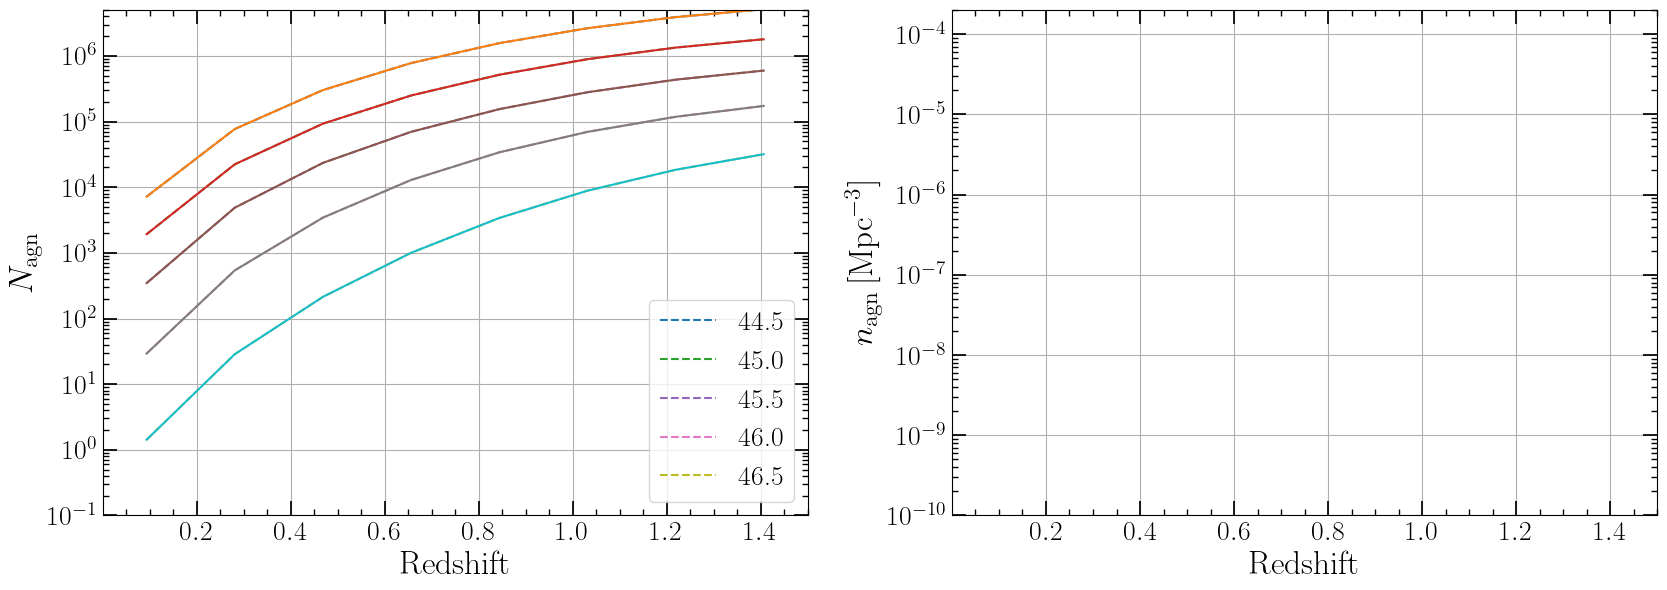

In [37]:
import astropy.units as u

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(17,6))

ZMIN = 1e-6
ZMAX = 1.5
Z_EDGES = np.linspace(ZMIN, ZMAX, 9)
z_mids = (Z_EDGES + np.roll(Z_EDGES, shift=1))[1:] / 2

R_EDGES = COSMO.comoving_distance(Z_EDGES).value

for Lthresh in [44.5, 45.0, 45.5, 46.0, 46.5]:
    thresh = Lthresh - 7  # log lumthresh in W
    magthresh = L2M(thresh)

    mag_integrate_axis = np.linspace(-50, magthresh, int(1024)+1)
    
    n_of_r = lambda r: romb(10**log10_QLF(mag_integrate_axis[:,np.newaxis], z=fast_z_at_value(COSMO.comoving_distance, r * u.Mpc))[np.newaxis,:], dx=np.diff(mag_integrate_axis)[0], axis=1)  # Function of comoving distance
    n_of_z = lambda z: romb(10**log10_QLF(mag_integrate_axis[:,np.newaxis], z=z[np.newaxis,:]), dx=np.diff(mag_integrate_axis)[0], axis=0)  # Function of redshift

    nums = []
    nums2 = []
    for i in tqdm(range(len(R_EDGES) - 1)):
        r_integrate_ax = np.linspace(R_EDGES[i], R_EDGES[i + 1], 256+1)
        numdens = n_of_r(r_integrate_ax)
        # print(numdens.shape)
        num = 4 * np.pi * romb(numdens * r_integrate_ax**2, dx=np.diff(r_integrate_ax)[0], axis=1)
        nums.append(num)

        z_integrate_ax = np.linspace(Z_EDGES[i], Z_EDGES[i + 1], 256+1)
        numdens2 = n_of_z(z_integrate_ax)
        # print(numdens2.shape)
        num2 = 4 * np.pi * romb(numdens2 * COSMO.differential_comoving_volume(z_integrate_ax).value, dx=np.diff(z_integrate_ax)[0])
        nums2.append(num2)

    ax1.plot(z_mids, nums, linestyle='dashed', label=Lthresh)
    ax1.plot(z_mids, nums2)

ax1.legend()
# ax1.vlines(Z_EDGES, 1e-1, 5e6)
ax1.grid()
ax1.semilogy()
ax1.set_xlim(ZMIN, ZMAX)
ax1.set_ylim(1e-1, 5e6)
ax1.set_xlabel('Redshift')
ax1.set_ylabel(r'$N_{\rm agn}$')

ax2.set_xlabel('Redshift')
ax2.set_ylabel(r'$n_{\rm agn} \, [\mathrm{Mpc^{-3}}]$')
ax2.grid()
ax2.set_xlim(ZMIN, ZMAX)
ax2.semilogy()
ax2.set_ylim(1e-10, 2e-4)
plt.tight_layout()
plt.show()


In [ ]:
CATALOG_PATH = "/home/lucas/Documents/PhD/Quaia_z15.csv"
lthreshes = [45.0, 45.5, 46.0, 46.5]

for LUM_THRESH in lthreshes:
    df = pd.read_csv(CATALOG_PATH)
    cols = ["redshift_quaia", "redshift_quaia_err", "ra", "dec", "b", "loglbol_corr"]
    data = df[cols]
    b              = data["b"].to_numpy()
    loglbol_corr   = data["loglbol_corr"].to_numpy()
    outside_galactic_plane = np.logical_or((b > 10), (b < -10))
    above_lbol_thresh = loglbol_corr >= float(LUM_THRESH)

    b                  = b[outside_galactic_plane & above_lbol_thresh]
    loglbol_corr       = loglbol_corr[outside_galactic_plane & above_lbol_thresh]
    agn_redshift       = data["redshift_quaia"].to_numpy()[outside_galactic_plane & above_lbol_thresh]
    agn_redshift_err   = data["redshift_quaia_err"].to_numpy()[outside_galactic_plane & above_lbol_thresh]
    agn_ra             = np.deg2rad( data["ra"].to_numpy()[outside_galactic_plane & above_lbol_thresh] )
    agn_dec            = np.deg2rad( data["dec"].to_numpy()[outside_galactic_plane & above_lbol_thresh] )
    agn_rlum           = COSMO.luminosity_distance(agn_redshift).value

    filename = f'./quaia_testing_{LUM_THRESH}_QLFPRIOR.hdf5'
    # compute_and_save_posteriors_hdf5(filename, agn_redshift, agn_redshift_err, prior=LUM_THRESH)


with h5py.File(f'./quaia_testing_45.0_QLFPRIOR.hdf5', "r") as f:
    agn_posterior_dset = f["agn_redshift_posteriors"][()]
SoP45_0 = np.sum(agn_posterior_dset, axis=0)  # Sum of posteriors is required to normalize the in-catalog population prior


with h5py.File(f'./quaia_testing_45.5_QLFPRIOR.hdf5', "r") as f:
    agn_posterior_dset = f["agn_redshift_posteriors"][()]
SoP45_5 = np.sum(agn_posterior_dset, axis=0)  # Sum of posteriors is required to normalize the in-catalog population prior


with h5py.File(f'./quaia_testing_46.0_QLFPRIOR.hdf5', "r") as f:
    agn_posterior_dset = f["agn_redshift_posteriors"][()]
SoP46_0 = np.sum(agn_posterior_dset, axis=0)  # Sum of posteriors is required to normalize the in-catalog population prior


with h5py.File(f'./quaia_testing_46.5_QLFPRIOR.hdf5', "r") as f:
    agn_posterior_dset = f["agn_redshift_posteriors"][()]
SoP46_5 = np.sum(agn_posterior_dset, axis=0)  # Sum of posteriors is required to normalize the in-catalog population prior


100%|██████████| 331/331 [00:35<00:00,  9.31it/s]


All AGN posteriors written to ./quaia_testing_45.0_QLFPRIOR.hdf5


100%|██████████| 252/252 [00:26<00:00,  9.50it/s]


All AGN posteriors written to ./quaia_testing_45.5_QLFPRIOR.hdf5


100%|██████████| 91/91 [00:09<00:00,  9.17it/s]


All AGN posteriors written to ./quaia_testing_46.0_QLFPRIOR.hdf5


100%|██████████| 11/11 [00:01<00:00, 10.13it/s]


All AGN posteriors written to ./quaia_testing_46.5_QLFPRIOR.hdf5


100%|██████████| 128/128 [00:00<00:00, 202.52it/s]


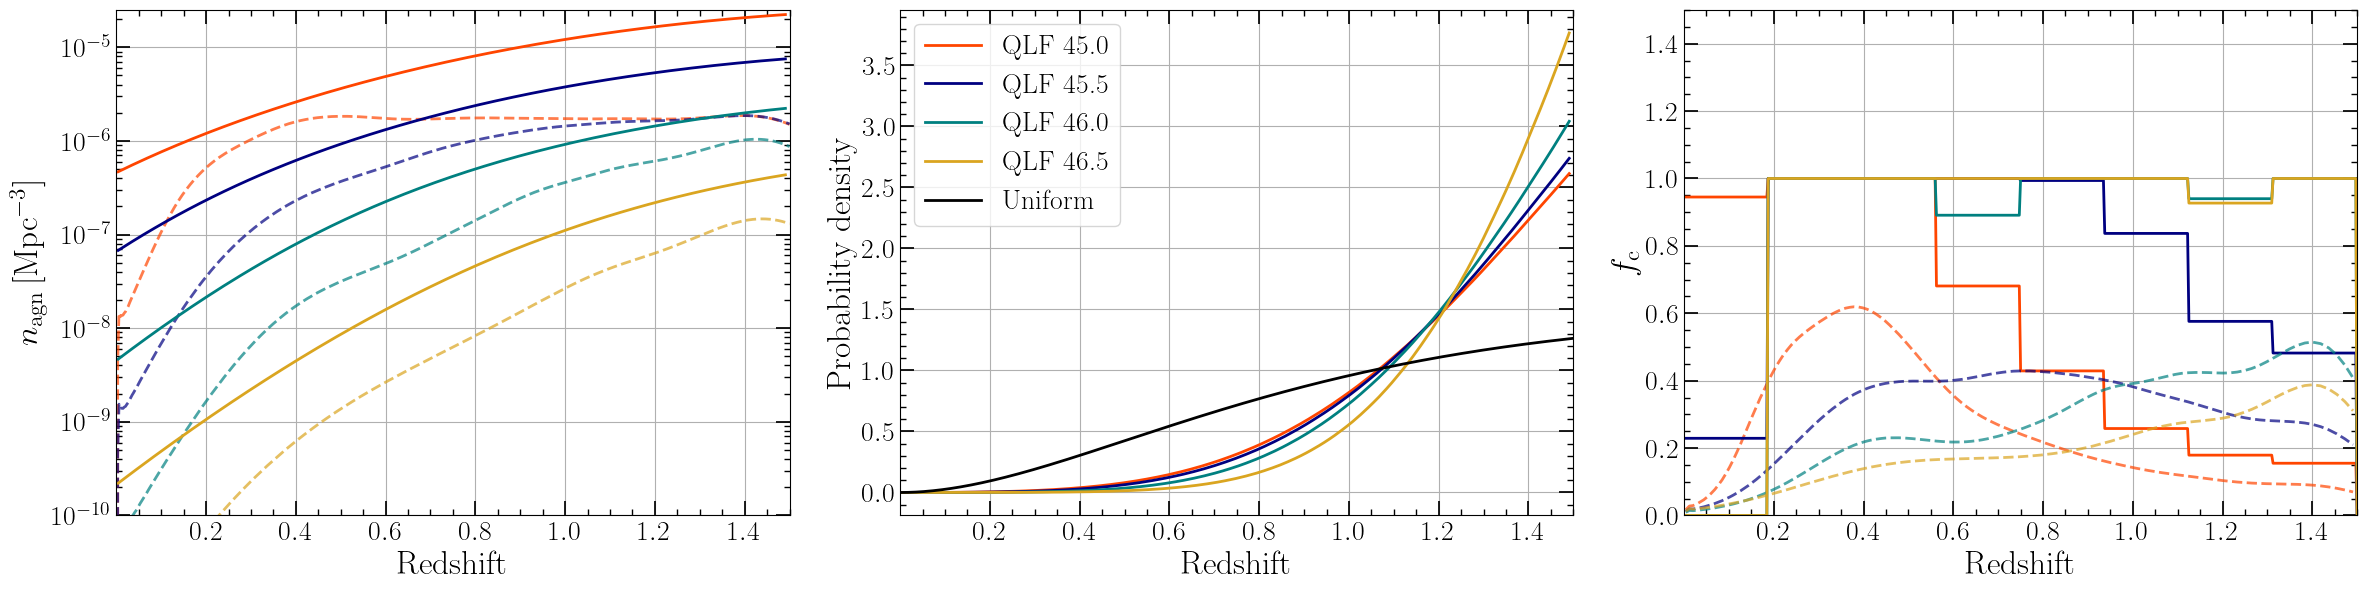

In [64]:
COLORS = ['orangered', 'navy', 'teal', 'goldenrod', 'indigo', 'crimson']

# z = np.linspace(1e-4, 7, 1000)
z = S_AGN_Z_INTEGRAL_AX
r = COSMO.comoving_distance(z).value      # Mpc
dr_dz = np.gradient(r, z)

# uniform_comoving_prior(z) ∝ r² dr/dz
N_unif = uniform_comoving_prior(z)
n_unif = N_unif / (4 * np.pi * r**2 * dr_dz)


def obs_numdens_of_z(z, sum_of_posteriors):
    n = sum_of_posteriors / (4 * np.pi * r**2 * dr_dz)
    return interp1d(x=S_AGN_Z_INTEGRAL_AX, y=n)(z)


ZMIN = 1e-4
ZMAX = 1.5
R_EDGES = np.linspace(COSMO.comoving_distance(ZMIN).value, COSMO.comoving_distance(ZMAX).value, 128+1)
r_mids = (R_EDGES + np.roll(R_EDGES, shift=1))[1:] / 2
z_mids = fast_z_at_value(COSMO.comoving_distance, r_mids * u.Mpc)

Z_EDGES = fast_z_at_value(COSMO.comoving_distance, R_EDGES * u.Mpc)
V25_zedges = np.array([0.0000, 0.1875, 0.3750, 0.5625, 0.7500, 0.9375, 1.1250, 1.3125, AGN_ZCUT, AGN_ZMAX])


fig, (ax2, ax3, ax1) = plt.subplots(1, 3, figsize=(24,6))

for i, (L_thresh, sum_of_posteriors) in enumerate(zip([45.0, 45.5, 46.0, 46.5], [SoP45_0, SoP45_5, SoP46_0, SoP46_5])):
    magthresh = L2M(L_thresh - 7)
    mag_integrate_axis = np.linspace(-50, magthresh, int(1024)+1)

    n_of_r = lambda r: romb(10**log10_QLF(mag_integrate_axis[:,np.newaxis], z=fast_z_at_value(COSMO.comoving_distance, r * u.Mpc))[np.newaxis,:], dx=np.diff(mag_integrate_axis)[0], axis=1)  # Function of comoving distance
    numdenses = n_of_r(r_mids).flatten()

    ax1.plot(z_mids, obs_numdens_of_z(z_mids, sum_of_posteriors) / numdenses, label=f'Observed {L_thresh}', color=COLORS[i], linewidth=2, linestyle='dashed', alpha=0.7)
    ax1.plot(S_AGN_Z_INTEGRAL_AX, redshift_completeness(S_AGN_Z_INTEGRAL_AX, V25_zedges, np.array(QUAIA_C_VALS[:, THRESHOLD_MAP[str(L_thresh)]])), linewidth=2, label=f'V25 {L_thresh}', color=COLORS[i])

    ax2.plot(z_mids, numdenses, label=f'QLF {L_thresh}', color=COLORS[i], linewidth=2)

    n_obs = obs_numdens_of_z(z, sum_of_posteriors)
    ax2.plot(z, n_obs, label='Observed', color=COLORS[i], linewidth=2, linestyle='dashed', alpha=0.7)

    nums = []
    for j in tqdm(range(len(R_EDGES) - 1)):
        r_integrate_ax = np.linspace(R_EDGES[j], R_EDGES[j + 1], 256+1)
        numdens = n_of_r(r_integrate_ax)
        num = 4 * np.pi * romb(numdens * r_integrate_ax**2, dx=np.diff(r_integrate_ax)[0], axis=1)
        nums.append(num)
    nums = np.array(nums).flatten()
    newz = np.linspace(z_mids[0], z_mids[-1], 256+1)
    nums = interp1d(z_mids, nums)(newz)

    ax3.plot(newz, nums / romb(nums, dx=np.diff(newz)[0]), label=f'QLF {L_thresh}', color=COLORS[i], linewidth=2)
    
    # np.save('z_ax.npy', newz)
    # np.save(f'zprior_{L_thresh}.npy', nums / romb(nums, dx=np.diff(newz)[0]))


ax1.grid()
ax1.set_xlim(ZMIN, ZMAX)
ax1.set_xlabel('Redshift')
ax1.set_ylabel(r'$f_{\rm c}$')
# ax1.legend()
# ax1.semilogy()
ax1.set_ylim(0, 1.5)

# ax2.plot(z, n_unif / np.mean(n_unif) * 1e-6, label='Uniform', color='black', linewidth=2)
ax2.set_xlabel('Redshift')
ax2.set_ylabel(r'$n_{\rm agn} \, [\mathrm{Mpc^{-3}}]$')
ax2.grid()
ax2.set_xlim(ZMIN, ZMAX)
ax2.set_ylim(1e-10, 2.5e-5)
ax2.semilogy()
# ax2.legend()

ax3.set_xlabel('Redshift')
ax3.set_ylabel('Probability density')
ax3.plot(z, uniform_comoving_prior(z) / romb(uniform_comoving_prior(z), dx=np.diff(z)[0]), label='Uniform', color='black', linewidth=2)
ax3.legend()
ax3.grid()
ax3.set_xlim(ZMIN, ZMAX)

plt.tight_layout()
plt.show()
